# Advanced Lane Lines Project

Goal of this project is to build a pipeline to detect lane lines in a video. We use traditional computer vision techniques like camera calibration, thresholding, perspective transform and lsiding window approach to detect the lane lines.

## Finding corners in a chess board

['camera_cal/calibration10.jpg', 'camera_cal/calibration2.jpg', 'camera_cal/calibration12.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration8.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration9.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration20.jpg', 'camera_cal/calibration1.jpg', 'camera_cal/calibration5.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration14.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration3.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration6.jpg']


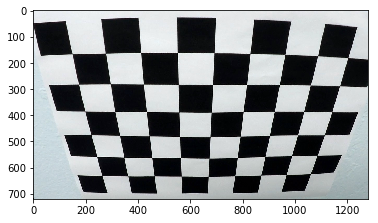

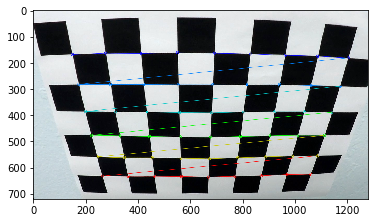

In [9]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# Get the file names
fileNames = glob.glob('camera_cal/*.jpg')

# Read the image
image = cv2.imread(fileNames[1])
plt.imshow(image)
plt.show()

# Convert to grayscale
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Find the corners in chessboard
pointsPerRow = 9
pointsPerCol = 6

patternSize = (pointsPerRow,pointsPerCol)
retVal, cornerPoints = cv2.findChessboardCorners(grayImage, patternSize)

# Draw the chessboard corners
cv2.drawChessboardCorners(image, patternSize, cornerPoints, retVal)
plt.imshow(image)
plt.show()

retVal = cv2.imwrite('output_images/findChessBoard_Output.png',image)

## Calibrate camera and undistort image

In [2]:
# Calibrate Camera
def calibrateCamera(fileNames, patternSize):
    """ Calibrates the camera using the opencv 
    calibrateCamera function, It takes in the list
    of filenames nd returns the outputs of the opencv function"""

    patternPoints = np.zeros((pointsPerCol * pointsPerRow,3), np.float32)
    patternPoints[:,:2] = np.mgrid[0:patternSize[0], 0:patternSize[1]].T.reshape(-1,2)

    objectPoints = []
    imagePoints = []

    for fileName in fileNames:
        image = cv2.imread(fileName)
        grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        retVal, cornerPoints = cv2.findChessboardCorners(grayImage, patternSize)

        if retVal:
            objectPoints.append(patternPoints)
            imagePoints.append(cornerPoints)
            

    imageSize = (image.shape[1], image.shape[0])
    retVal, cameraMatrix, distCoeff, rotVec, transVec = cv2.calibrateCamera( objectPoints, imagePoints, imageSize,
                                                                            None, None)            

    return cameraMatrix, distCoeff, rotVec, transVec

# Undistort image
def undistortImage(image, cameraMatrix, distCoeff):
    
    undistortedImage = cv2.undistort(image, cameraMatrix, distCoeff, cameraMatrix)
    return undistortedImage

# Convert an image to rgb image
def getRGBImage(image):
    rgbImage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB);
    return rgbImage

In [14]:
#Calibrate camera and undistort the image
patternSize = (9,6)
cameraMatrix, distCoeff, rotVec, transVec = calibrateCamera(fileNames, patternSize)


### Undistort a calibration image

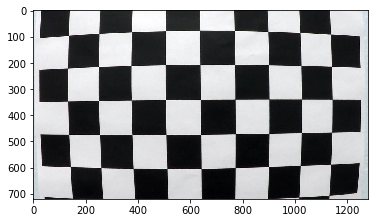

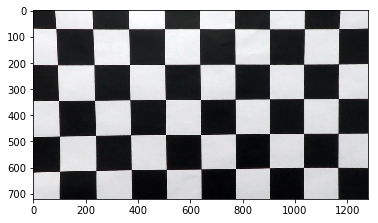

In [15]:
# Undistort a test image
testImage = cv2.imread(fileNames[10])
plt.imshow(testImage)
plt.show()

undistortedImage = undistortImage(testImage, cameraMatrix, distCoeff)
plt.imshow(undistortedImage)
plt.show()

retVal = cv2.imwrite('output_images/undistorted_output.png',undistortedImage)

### Undistort test image

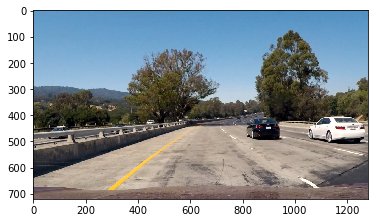

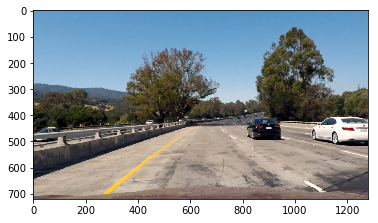

In [16]:
# Undistort a test image
testImage = cv2.imread('test_images/test1.jpg')
plt.imshow(getRGBImage(testImage))
plt.show()

undistortedImage = undistortImage(testImage, cameraMatrix, distCoeff)
plt.imshow(getRGBImage(undistortedImage))
plt.show()

retVal = cv2.imwrite('output_images/undistorted_test_output.png',undistortedImage)

## Thresholding and perspective transform

In [18]:
def sobel(image, kernelSize, magnitudeThresh, directionThresh):
    """ Apply the sobel operator on the image. The method takes in
    the kernelSize which should be an odd number, threshold for
    magnitude and direction. It returns a binary image with the 
    thresholds applied """
    
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sobelx = cv2.Sobel(grayImage, cv2.CV_64F, 1, 0, kernelSize)
    sobely = cv2.Sobel(grayImage, cv2.CV_64F, 0, 1, kernelSize)
    
    # Magnitude of the sobel operation
    gradMagImage = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scaleFactor = np.max(gradMagImage)/255 
    gradMagImage = (gradMagImage/scaleFactor).astype(np.uint8)   
    
    # Apply magnitude threshold and create a binary image
    gradMagBinary = np.zeros_like(gradMagImage)
    gradMagBinary[(gradMagImage >= magnitudeThresh[0]) & (gradMagImage <= magnitudeThresh[1])] = 1
    
    # Calculate direction image and apply threshold to create 
    # binary image
    gradDirImage = np.arctan2( np.absolute(sobely), np.absolute(sobelx) )
    gradDirBinary = np.zeros_like(gradDirImage)
    gradDirBinary[(gradDirImage >= directionThresh[0]) & (gradDirImage <= directionThresh[1])] = 1
    
    # Combine the binary images
    binaryImage = np.zeros_like(gradMagImage)
    binaryImage[(gradMagBinary==1) & (gradDirBinary==1)] = 1
   
    return binaryImage

def colorThreshold(image):
    """ Threshold the image on the Saturation channel"""
    
    hlsImage = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    
    hImage = hlsImage[:,:,0]
    lImage = hlsImage[:,:,1]
    sImage = hlsImage[:,:,2]
    
    yellowLine = np.zeros_like(sImage)
    yellowLine[ ((hImage > 15) & (hImage < 25)) & ((lImage > 100) & (lImage < 165)) & (sImage > 180) & (sImage <= 255) ] = 1

    rImage = image[:,:,2]
    gImage = image[:,:,1]
    bImage = image[:,:,0]
    
    whiteLine = np.zeros_like(rImage)
    whiteLine[ ((rImage > 200) & (rImage <= 255)) & ((gImage > 200) & (gImage <= 255)) & (bImage > 200) & (bImage <= 255) ] = 1
    
    binaryImage = yellowLine | whiteLine
   
    return binaryImage

def transformImage(image, srcPoints, dstPoints):
    """ This method applies perspective transform to the image"""
    transformMatrix = cv2.getPerspectiveTransform(srcPoints, dstPoints);
    imageSize = (image.shape[1], image.shape[0])
    transformedImg = cv2.warpPerspective(image, transformMatrix, imageSize)
    
    return transformedImg

### Color threshold a image

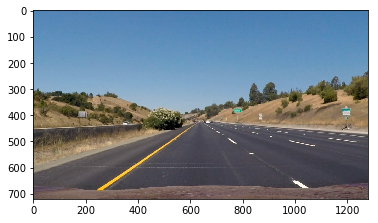

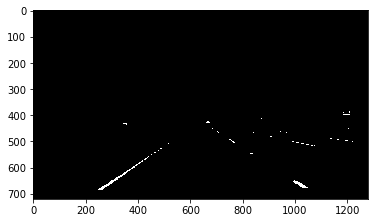

In [47]:
# Load the image

image = cv2.imread('test_images/straight_lines1.jpg')

plt.imshow(getRGBImage(image))
plt.show()

resultImage = colorThreshold(image)
plt.imshow(resultImage, cmap='gray')
plt.show()

retVal = cv2.imwrite('output_images/color_thresholded.png',resultImage*255)

### Perspective transform of an image

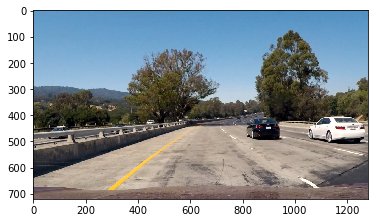

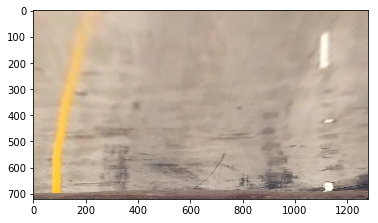

In [28]:
# Load the image

image = cv2.imread('test_images/test1.jpg')

plt.imshow(getRGBImage(image))
plt.show()

imageSize = image.shape

srcPoints = np.float32([ [263,imageSize[0]], [560,470], [720,470], [1046,imageSize[0]] ])
dstPoints = np.float32([ [100,imageSize[0]], [100,0], [1000,0], [1000,imageSize[0]] ])

transformedImage = transformImage(image, srcPoints, dstPoints)

plt.imshow(getRGBImage(transformedImage))
plt.show()

retVal = cv2.imwrite('output_images/transformed.png',transformedImage)

## Pipeline

In [51]:
# Pipeline with a simple test image

def pipeline(image):
    
    global leftFit, rightFit
    global bgr
    global leftFitCur, rightFitCur

    # Undistort
    undistortedImage = undistortImage(image, cameraMatrix, distCoeff)

    # Apply color threshold
    if bgr == 0:
        undistortedImage = cv2.cvtColor(undistortedImage, cv2.COLOR_RGB2BGR)
        
    binaryColorThreshImage = colorThreshold(undistortedImage)
    binaryImage = binaryColorThreshImage
    
    # Apply perspective transform

    imageSize = binaryImage.shape

    srcPoints = np.float32([ [263,imageSize[0]], [560,470], [720,470], [1046,imageSize[0]] ])
    dstPoints = np.float32([ [100,imageSize[0]], [100,0], [1000,0], [1000,imageSize[0]] ])

    transformedImage = transformImage(binaryImage, srcPoints, dstPoints)

    if len(leftFit) == 0:

        # Histogram of the lower half of the image
        histogram = np.sum(transformedImage[transformedImage.shape[0]//2:,:], axis=0)

        midpoint = np.int(histogram.shape[0]/2)
        leftPeak = np.argmax(histogram[:midpoint])
        rightPeak = np.argmax(histogram[midpoint:]) + midpoint

        numberOfWindows = 9
        windowWidth = 100
        minimumPixels = 50

        windowHeight = np.int(transformedImage.shape[0]/numberOfWindows)

        leftLaneIndx = []
        rightLaneIdx = []

        leftCurrent = leftPeak
        rightCurrent = rightPeak

        # x,y positions of all non zero pixels
        nonzero = transformedImage.nonzero()
        nonzeroY = np.array(nonzero[0])
        nonzeroX = np.array(nonzero[1])

        for window in range(numberOfWindows):

            windowYLow = transformedImage.shape[0] - (window+1)*windowHeight
            windowYHigh = transformedImage.shape[0] - (window)*windowHeight

            windowXLeftLow =  leftCurrent - windowWidth
            windowXLeftHigh = leftCurrent + windowWidth
            windowXRightLow = rightCurrent - windowWidth
            windowXRightHigh = rightCurrent + windowWidth
            
            leftIdxs = ((nonzeroY >= windowYLow) & (nonzeroY < windowYHigh) & 
            (nonzeroX >= windowXLeftLow) &  (nonzeroX < windowXLeftHigh)).nonzero()[0]

            rightIdxs = ((nonzeroY >= windowYLow) & (nonzeroY < windowYHigh) & 
            (nonzeroX >= windowXRightLow) &  (nonzeroX < windowXRightHigh)).nonzero()[0]

            leftLaneIndx.append(leftIdxs)
            rightLaneIdx.append(rightIdxs)

            if len(leftIdxs) > minimumPixels:
                leftCurrent = np.int(np.mean(nonzeroX[leftIdxs]))
            if len(rightIdxs) > minimumPixels:        
                rightCurrent = np.int(np.mean(nonzeroX[rightIdxs]))

        leftLaneIndx = np.concatenate(leftLaneIndx)
        rightLaneIdx = np.concatenate(rightLaneIdx)

        leftX = nonzeroX[leftLaneIndx]
        leftY = nonzeroY[leftLaneIndx]
        rightX = nonzeroX[rightLaneIdx]
        rightY = nonzeroY[rightLaneIdx]

        leftFit = np.polyfit(leftY, leftX, 2)
        rightFit = np.polyfit(rightY, rightX, 2)
    else:
        
        # x,y positions of all non zero pixels
        nonzero = transformedImage.nonzero()
        nonzeroY = np.array(nonzero[0])
        nonzeroX = np.array(nonzero[1])        
        windowWidth = 100
        
        leftLaneIndx = ((nonzeroX > (leftFit[0]*(nonzeroY**2) + leftFit[1]*nonzeroY + 
        leftFit[2] - windowWidth)) & (nonzeroX < (leftFit[0]*(nonzeroY**2) + 
        leftFit[1]*nonzeroY + leftFit[2] + windowWidth))) 

        rightLaneIdx = ((nonzeroX > (rightFit[0]*(nonzeroY**2) + rightFit[1]*nonzeroY + 
        rightFit[2] - windowWidth)) & (nonzeroX < (rightFit[0]*(nonzeroY**2) + 
        rightFit[1]*nonzeroY + rightFit[2] + windowWidth)))  

        # Again, extract left and right line pixel positions
        leftX = nonzeroX[leftLaneIndx]
        leftY = nonzeroY[leftLaneIndx] 
        rightX = nonzeroX[rightLaneIdx]
        rightY = nonzeroY[rightLaneIdx]

        # Fit a second order polynomial to each
        if leftY.size != 0 or leftX.size != 0:
            leftFit = np.polyfit(leftY, leftX, 2)
            
        if rightY.size != 0 or rightX.size != 0:            
            rightFit = np.polyfit(rightY, rightX, 2)

    ploty = np.linspace(0, transformedImage.shape[0]-1, transformedImage.shape[0] )
    leftFitX = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
    rightFitX = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2] 
    
    # Create an image to draw the lines on
    transformedZero = np.zeros_like(transformedImage).astype(np.uint8)
    colorTransformedImg = np.dstack((transformedZero, transformedZero, transformedZero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ptsLeft = np.array([np.transpose(np.vstack([leftFitX, ploty]))])
    ptsRight = np.array([np.flipud(np.transpose(np.vstack([rightFitX, ploty])))])
    pts = np.hstack((ptsLeft, ptsRight))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(colorTransformedImg, np.int_([pts]), (0,255, 0))

    Minv = cv2.getPerspectiveTransform(dstPoints, srcPoints)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(colorTransformedImg, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistortedImage, 1, newwarp, 0.3, 0)
    
    yEval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    yMeterPerPix = 30/720 # meters per pixel in y dimension
    xMeterPerPix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    if leftX.size != 0:
        leftFitCur = np.polyfit(leftY*yMeterPerPix, leftX*xMeterPerPix, 2)
        
    if rightX.size != 0:
        rightFitCur = np.polyfit(rightY*yMeterPerPix, rightX*xMeterPerPix, 2)

    # Calculate the new radii of curvature
    leftRadcurvature = ( (1 + (2 * leftFitCur[0] * yEval * yMeterPerPix + leftFitCur[1]) ** 2) ** 
                        1.5) /  np.absolute(2*leftFitCur[0]);
    
    rightRadCurvature = ( (1 + (2 * rightFitCur[0] * yEval * yMeterPerPix + rightFitCur[1]) **2) ** 
                         1.5) / np.absolute(2*rightFitCur[0])    

    leftLane = (leftFit[0]*yEval**2 + leftFit[1]*yEval + leftFit[2])
    rightLane = (rightFit[0]*yEval**2 + rightFit[1]*yEval + rightFit[2])
        
    laneMidPoint = (leftLane+rightLane)/2.0
        
    offsetFromCenterImg = transformedImage.shape[1]/2.0 - laneMidPoint
        
    distanceInMetres = xMeterPerPix*offsetFromCenterImg
        
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    radCurText = str('Radius Curvature: Left = ' + str(leftRadcurvature) +' m' + 
                     ' Right = ' + str(rightRadCurvature) +' m')
    cv2.putText(result,radCurText,(20,100), font, 1,(255,255,255),2,cv2.LINE_AA)

    distText = str('Distance from center: '+ str(distanceInMetres)+'m')
    cv2.putText(result,distText,(20,150), font, 1,(255,255,255),2,cv2.LINE_AA)    
    
    if bgr == 0:
        result = getRGBImage(result)
        
    return result


## Image pipeline test

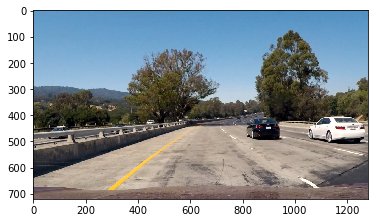

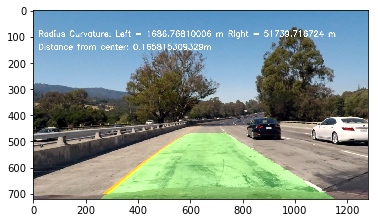

In [53]:
# Load the image

image = cv2.imread('test_images/test1.jpg')

plt.imshow(getRGBImage(image))
plt.show()

leftFit = []
rightFit = []
bgr  = 1

resultImage = pipeline(image)
plt.imshow(getRGBImage(resultImage))
plt.show()

retVal = cv2.imwrite('output_images/output.png',resultImage)

## Video pipeline

In [285]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

projectVideo_output = "project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")

leftFit = [];
rightFit = [];
imageNumber = 0
bgr = 0;

clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip.write_videofile(projectVideo_output, audio=False)



[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:57<00:00,  7.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 9min 21s, sys: 4.22 s, total: 9min 25s
Wall time: 2min 59s


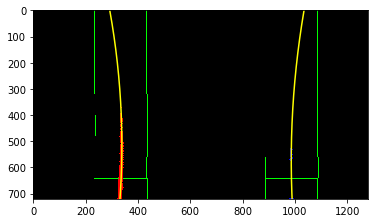

In [63]:
ploty = np.linspace(0, transformedImage.shape[0]-1, transformedImage.shape[0] )
left_fitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
right_fitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]

out_img[nonzeroY[leftLaneIndx], nonzeroX[leftLaneIndx]] = [255, 0, 0]
out_img[nonzeroY[rightLaneIdx], nonzeroX[rightLaneIdx]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.show()